In [184]:
import pandas as pd
import numpy as np
import scipy as sp
import Data as data
import Model as model 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_scaled_error
from prophet.diagnostics import cross_validation
from math import sqrt
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
DUK = data.get_ETF_data('DUK', '2000-01-01', '2024-01-01')

In [3]:
train_duk, val_duk, test_duk = data.split_time_series(DUK, 0.6,0.2)

In [4]:
display(DUK.head(10))

,adj_close
date,
2000-01-03,13.823437
2000-01-04,14.038309
2000-01-05,14.700115
2000-01-06,15.006666
2000-01-07,15.399166
2000-01-10,15.381976
2000-01-11,15.184294
2000-01-12,15.364786
2000-01-13,15.487980


# EDA

In [5]:
data.check_data_summary(DUK)

Number of rows: 6037
Number of columns: 1
Column names:
Index(['adj_close'], dtype='object')
Data types:
adj_close    float64
dtype: object
Summary statistics:
         adj_close
count  6037.000000
mean     43.832968
std      25.641930
min       8.004714
25%      22.856716
50%      37.012400
75%      62.755521
max     105.222359
Missing values:
adj_close    0
dtype: int64
No duplicated index values.


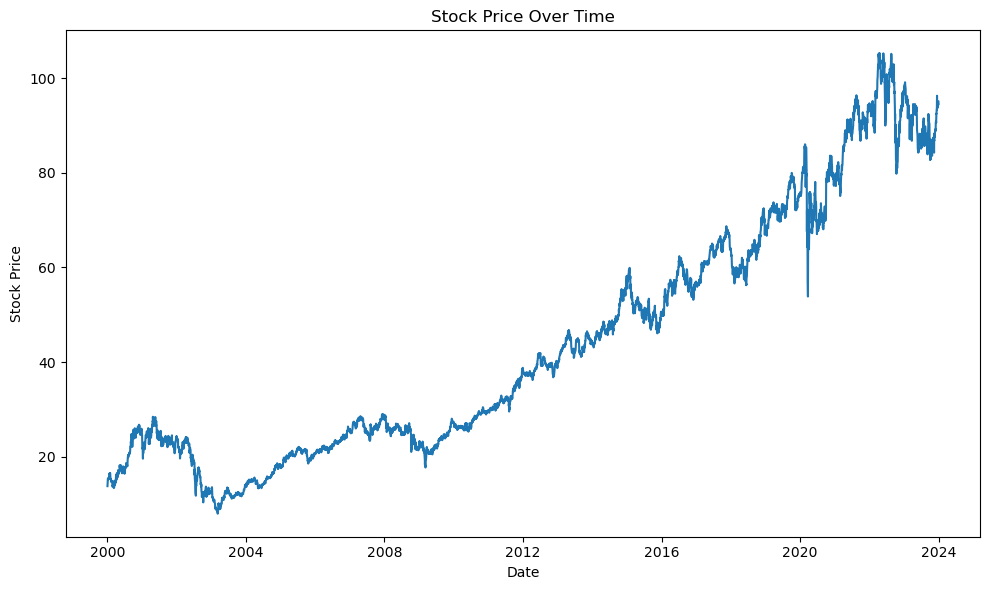

In [6]:
data.plot_stock_price(DUK)

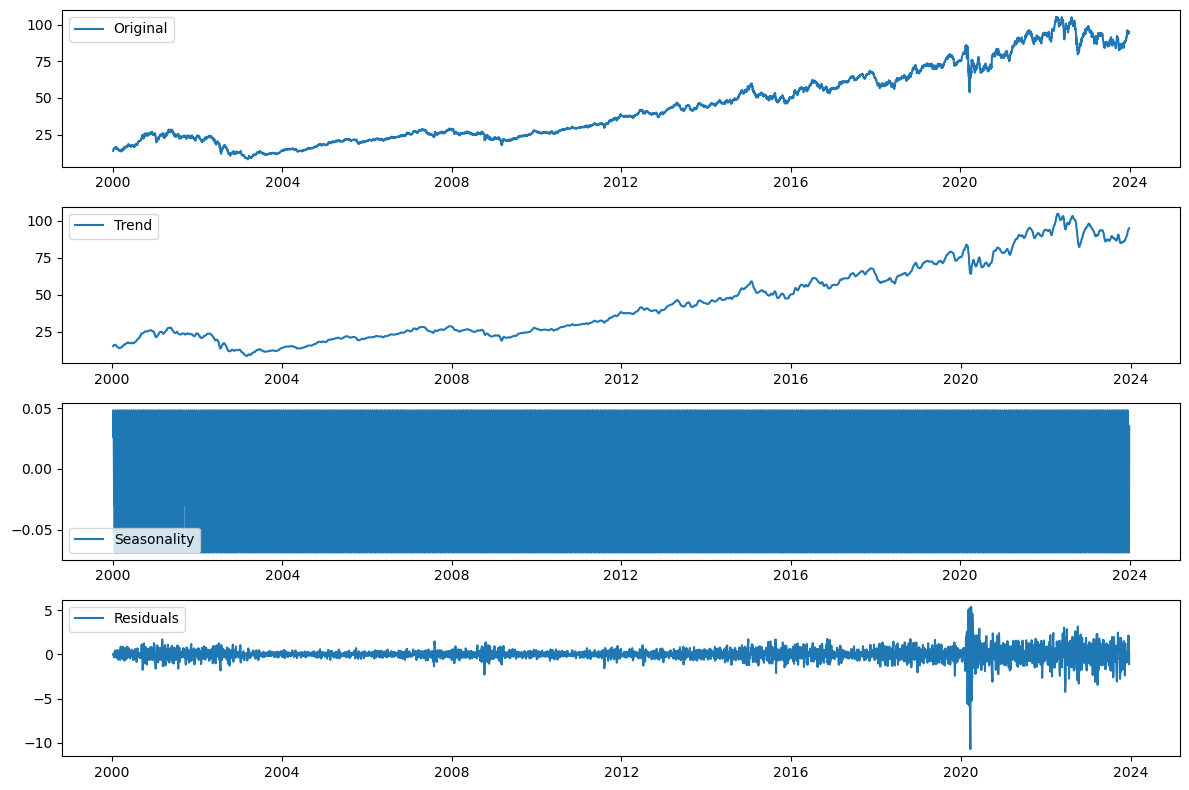

In [7]:
data.decompose_and_plot(DUK,12)

# Smoothing

In [8]:
def fit_smoothing(df,method='mul',period=12):
    
    fit = ExponentialSmoothing(df,
                            trend=method,
                            seasonal_periods=period, 
                            seasonal=method
                           ).fit()
    return fit

In [9]:
model_smoothing = fit_smoothing(train_duk)
y_test = val_duk
y_pred = model_smoothing.forecast(len(y_test))
y_pred.index = y_test.index

In [10]:
def evaluation(method_fit,y_test):
    # Fit the model, with selected alpha value
    fit = method_fit
    # Forecast over testing period
    y_pred = fit.forecast(len(y_test))
    y_pred.index = y_test.index
    
    # Calculate smape of test set performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test))
    smape = np.mean(2*np.abs(y_pred - y_test) / ((np.abs(y_test) + np.abs(y_pred))))
    return [mae,mse,mape,smape]

In [11]:
def tune_param(train,val,methods=['add','mul'],periods=[4,12,24,36]):
    result = []
    
    for method in methods:
        for period in periods:
            model = fit_smoothing(train,method,period)
            evaluation_i = evaluation(model,val)

            result_i = pd.Series([method,period]+evaluation_i)
            result.append(result_i)

    result = pd.concat(result,axis=1).T
    result.columns = ['methods','periods','mae','mse','mape','smape']

    return result

In [12]:
result = tune_param(train_duk,val_duk['adj_close'],methods=['add','mul'],periods=[4,12,24,36])
result

,methods,periods,mae,mse,mape,smape
0,add,4,6.031014,51.699284,0.098821,0.105748
1,add,12,6.011485,51.434383,0.098488,0.105375
2,add,24,5.973722,50.914942,0.097851,0.104657
3,add,36,6.001729,51.292716,0.098326,0.105191
4,mul,4,3.136852,15.174405,0.053195,0.05477
5,mul,12,3.109385,14.878101,0.052772,0.054276
6,mul,24,3.078611,14.543796,0.052304,0.053724
7,mul,36,3.101652,14.805973,0.05267,0.054152


In [13]:
best_param = result.loc[result['smape'].idxmin(), ['methods', 'periods']].tolist()
best_param 

['mul', 24]

# SARIMA 

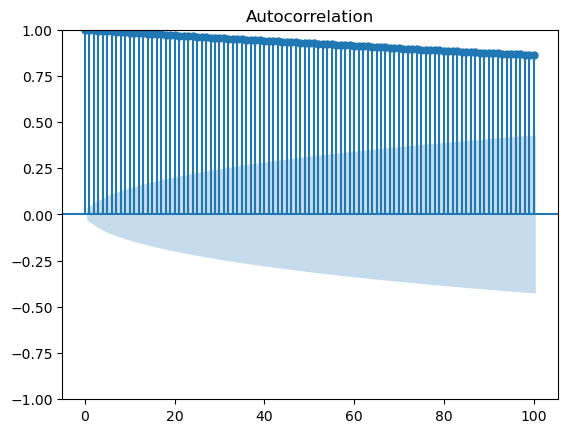

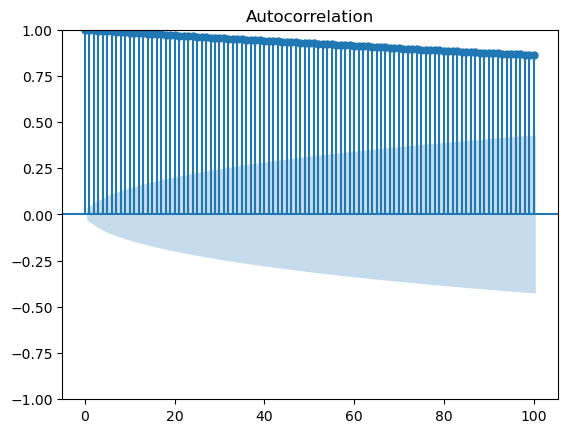

In [14]:
plot_acf(train_duk,lags=100)

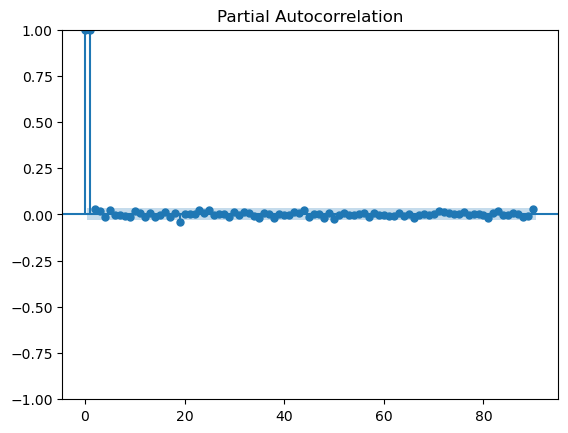

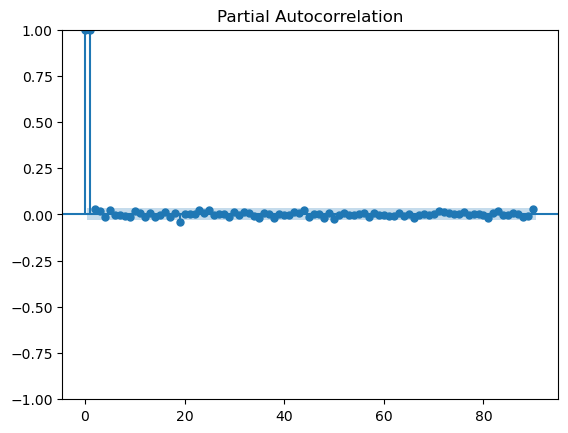

In [15]:
plot_pacf(train_duk['adj_close'],lags=90)

In [16]:
def adf_test(ts):
    display("Results of ADF Test:")
    dftest = adfuller(ts, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    display(dfoutput)

# KPSS test
def kpss_test(ts):
    display("Results of KPSS Test:")
    kpsstest = kpss(ts, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    display(kpss_output)

In [17]:
train_duk_sdiff = train_duk['adj_close'].diff(64).dropna() # monthly
train_duk_sdiff_diff = train_duk_sdiff.diff(1).dropna()
#train_duk_sdiff_diff.index = train_duk_sdiff_diff.index.to_timestamp()

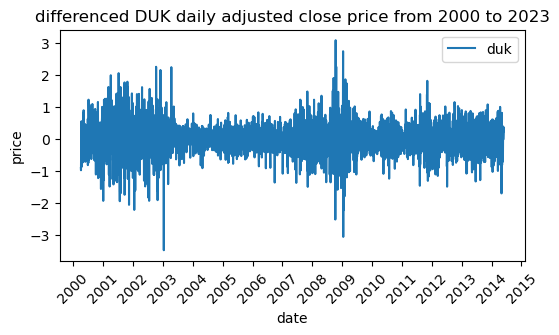

In [18]:
plt.figure(figsize=(6,3))
plt.plot(train_duk_sdiff_diff,label='duk')
plt.title('differenced DUK daily adjusted close price from 2000 to 2023')
plt.xlabel('date')
plt.ylabel('price')
# Set the locator
locator = mdates.AutoDateLocator(minticks=15, maxticks=20)
plt.gca().xaxis.set_major_locator(locator)
# Rotate dates for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [19]:
adf_test(train_duk_sdiff_diff)

'Results of ADF Test:'

Test Statistic                -1.734563e+01
p-value                        5.308060e-30
#Lags Used                     1.100000e+01
Number of Observations Used    3.545000e+03
Critical Value (1%)           -3.432196e+00
Critical Value (5%)           -2.862356e+00
Critical Value (10%)          -2.567204e+00
dtype: float64

In [20]:
kpss_test(train_duk_sdiff_diff)

'Results of KPSS Test:'

Test Statistic           0.009356
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

To conclude, after taking the lag 1 difference, the DUK daily adjusted close data is transformed into a stationary time series data.

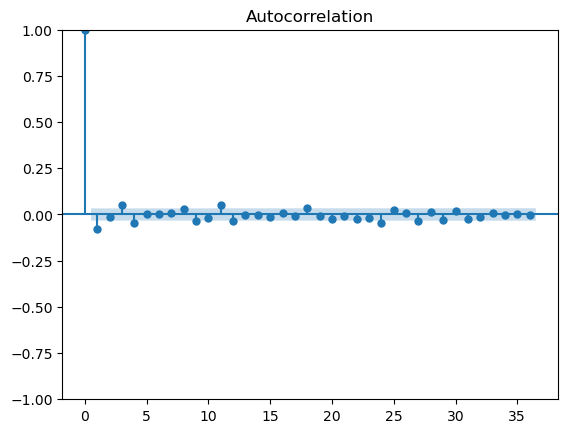

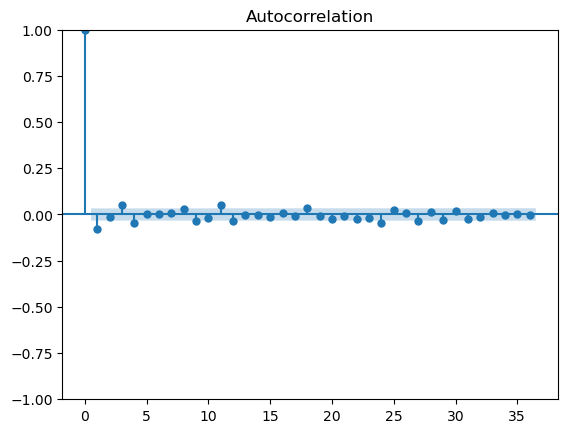

In [21]:
plot_acf(train_duk_sdiff_diff)

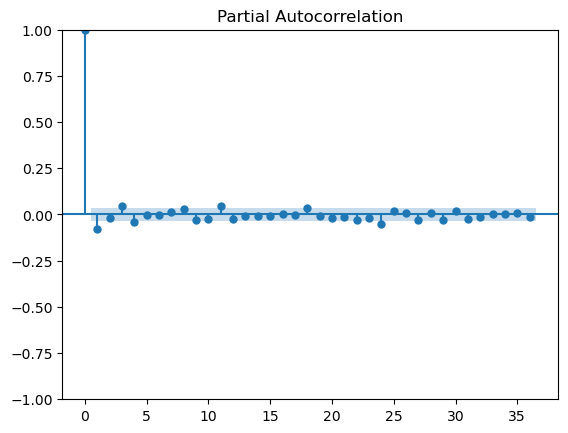

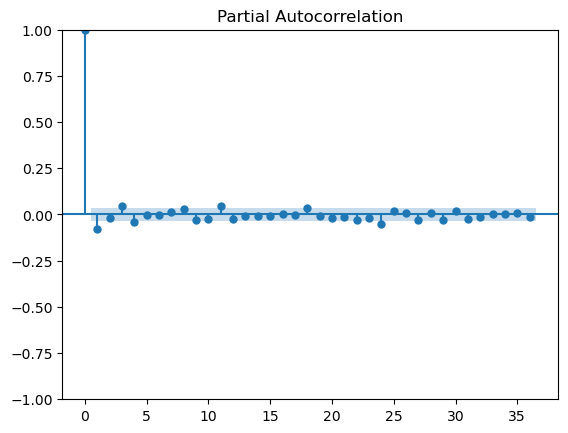

In [22]:
plot_pacf(train_duk_sdiff_diff)

In [23]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=train_duk,order=(1,1,1), seasonal_order=(0, 1, 1, 64)).fit(method='cg')
display(sarima_model.summary())

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          adj_close   No. Observations:                 3622
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 64)   Log Likelihood               -3214.423
Date:                            Thu, 23 May 2024   AIC                           6436.847
Time:                                    16:00:30   BIC                           6461.553
Sample:                                         0   HQIC                          6445.657
                                           - 3622                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0001      0.053      0.002      0.998      -0.104       0.104
ma.L1         -0.0821      0.052     -1.569      0.117      -0.185       0.020
ma.S.L64      -0.3924      0.005    -79.105      0.000      -0.402      -0.383
sigma2         0.0686      0.000    164.852      0.000       0.068       0.069
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):              1855.34
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
sarima_model2 = sm.tsa.statespace.SARIMAX(endog=train_duk,order=(0,1,0), seasonal_order=(1, 1, 1, 64)).fit(method='cg')
display(sarima_model2.summary())

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            adj_close   No. Observations:                 3622
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 64)   Log Likelihood               -1694.467
Date:                              Thu, 23 May 2024   AIC                           3394.935
Time:                                      16:00:49   BIC                           3413.465
Sample:                                           0   HQIC                          3401.542
                                             - 3622                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L64      -0.0453      0.023     -1.999      0.046      -0.090      -0.001
ma.S.L64      -0.6748      0.020    -33.476      0.000      -0.714      -0.635
sigma2         0.1605      0.002     64.917      0.000       0.156       0.165
===================================================================================
Ljung-Box (L1) (Q):                  12.07   Jarque-Bera (JB):              2674.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
sarima_model3 = sm.tsa.statespace.SARIMAX(endog=train_duk,order=(1,1,0), seasonal_order=(0, 1, 1, 64)).fit(method='cg')
display(sarima_model3.summary())

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            adj_close   No. Observations:                 3622
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 64)   Log Likelihood               -3267.635
Date:                              Thu, 23 May 2024   AIC                           6541.269
Time:                                      16:01:20   BIC                           6559.799
Sample:                                           0   HQIC                          6547.877
                                             - 3622                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0498      0.005    -10.862      0.000      -0.059      -0.041
ma.S.L64      -0.3933      0.005    -80.829      0.000      -0.403      -0.384
sigma2         0.0673      0.000    168.302      0.000       0.067       0.068
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):              1921.81
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
sarima_model4 = sm.tsa.statespace.SARIMAX(endog=train_duk,order=(0,1,1), seasonal_order=(0, 1, 1, 64)).fit(method='cg')
display(sarima_model4.summary())

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          adj_close   No. Observations:                 3622
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 64)   Log Likelihood               -3212.213
Date:                            Thu, 23 May 2024   AIC                           6430.427
Time:                                    16:01:54   BIC                           6448.957
Sample:                                         0   HQIC                          6437.034
                                           - 3622                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0768      0.005    -16.768      0.000      -0.086      -0.068
ma.S.L64      -0.3924      0.005    -79.094      0.000      -0.402      -0.383
sigma2         0.0686      0.000    165.154      0.000       0.068       0.069
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):              1865.62
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model is SARIMA(0,1,0)(1,1,1,64)

# Residual Analysis 

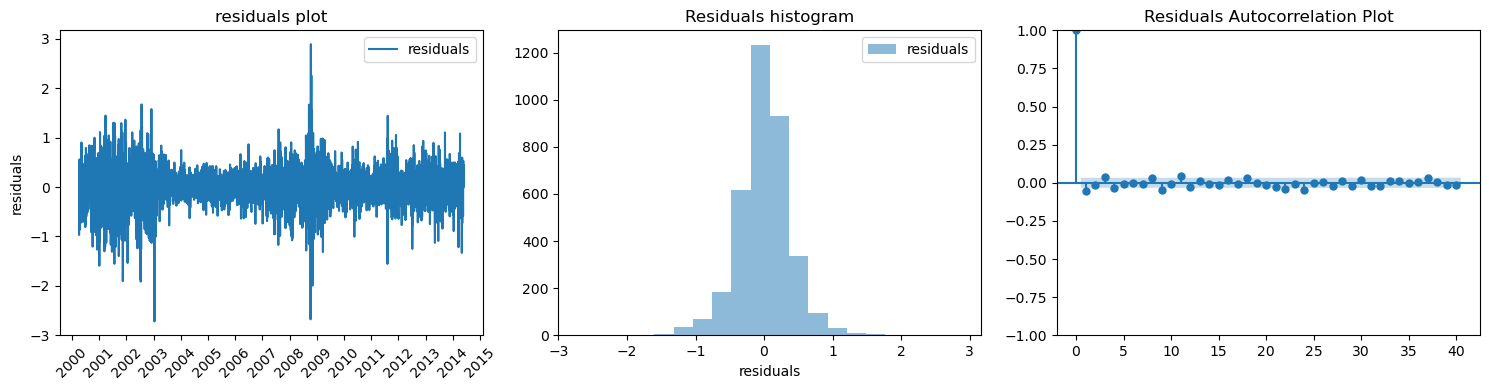

In [27]:
residuals = pd.DataFrame(sarima_model2.resid, columns=['residuals'])
#residuals.index = residuals.index.to_timestamp()
def resid_plot(resid):
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
    fig, axs = plt.subplots(1,3, figsize=(15, 4))  # 2 rows, 2 column

    # Residuals plot
    axs[0].plot(resid, label='residuals')
    axs[0].set_title('residuals plot')
    axs[0].xaxis.set_major_locator(locator)
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_ylabel('residuals')
    axs[0].legend()

    # Residuals histogram
    axs[1].hist(resid, alpha=0.5, bins=20, label='residuals')
    axs[1].set_title('Residuals histogram')
    axs[1].set_xlabel('residuals')
    axs[1].legend()

    # Residuals ACF plot
    plot_acf(resid, lags=40, ax=axs[2], title='Residuals Autocorrelation Plot')

    plt.tight_layout()
    plt.show()

resid_plot(residuals[65:])

In [28]:
sm.stats.acorr_ljungbox(residuals, lags=[12], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,24.316532,0.018415,24.255602,0.018772


In [29]:
def evaluation(test, predict, train, model_name):
    mae = mean_absolute_error(test, predict)
    mse = mean_squared_error(test, predict)
    mape = mean_absolute_percentage_error(test, predict)
    smape = mean_absolute_percentage_error(test, predict, symmetric=True)
    mase = mean_absolute_scaled_error(test, predict, y_train=train)
    evaluation_metrics = pd.DataFrame([mae, mse, mape, smape, mase],columns=[model_name], index=['mae','mse','mape','smape','mase'])
    return evaluation_metrics

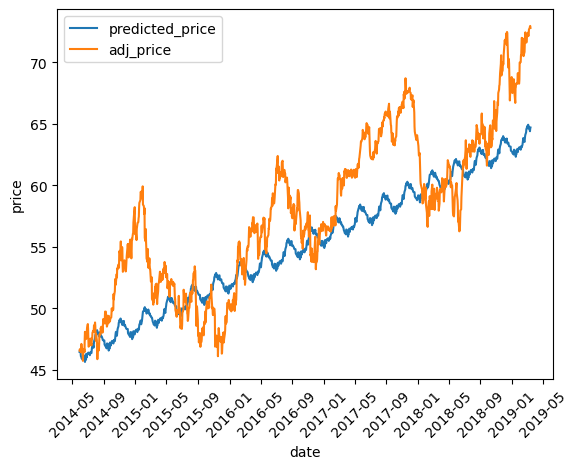

In [30]:
val_pred=sarima_model2.forecast(steps = len(val_duk)).to_frame()
val_pred.index = val_duk.index
plt.plot(val_pred['predicted_mean'], label='predicted_price')
plt.plot(val_duk['adj_close'], label='adj_price')
plt.xlabel('date')
plt.ylabel('price')
# Set the locator
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
plt.gca().xaxis.set_major_locator(locator)
# Rotate dates for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [31]:
sarima_eval = evaluation(val_duk,val_pred,train_duk,'SARIMA')
display(sarima_eval)

,SARIMA
mae,3.471726
mse,18.406996
mape,0.058228
smape,0.060306
mase,13.798814


# Auto-ARIMA

In [32]:
import warnings
warnings.filterwarnings('ignore')

import pmdarima as pm

In [33]:
autoarima_model = pm.auto_arima(train_duk, d=1, D=1, m=64, seasonal=False, stepwise=True)

In [34]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3622
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1364.108
Date:                Thu, 23 May 2024   AIC                           2742.215
Time:                        16:02:36   BIC                           2785.577
Sample:                             0   HQIC                          2757.664
                               - 3622                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0337      0.021      1.597      0.110      -0.008       0.075
ar.L1         -1.6472      0.035    -47.717      0.000      -1.715      -1.580
ar.L2         -1.0251      0.032    -31.783      0.000      -1.088      -0.962
ar.L3         -0.0752      0.012     -6.212      0.000      -0.099      -0.051
ma.L1          1.5914      0.033     48.205      0.000       1.527       1.656
ma.L2          0.9043      0.029     31.033      0.000       0.847       0.961
sigma2         0.1244      0.002     77.561      0.000       0.121       0.128
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3545.55
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
autosarima_model = pm.auto_arima(train_duk[-300:],  
                                 d=1, 
                                 D=1, 
                                 m=64,  
                                 seasonal=True, 
                                 stepwise=True,
                                 n_jobs=4)

In [38]:
autosarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  300
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 64)   Log Likelihood                -129.855
Date:                              Thu, 23 May 2024   AIC                            267.709
Time:                                      16:11:20   BIC                            281.548
Sample:                                           0   HQIC                           273.288
                                              - 300                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L64      -0.2423      0.444     -0.546      0.585      -1.112       0.628
ar.S.L128     -0.1321      0.223     -0.591      0.555      -0.570       0.306
ma.S.L64      -0.4431      0.503     -0.882      0.378      -1.428       0.542
sigma2         0.1523      0.017      9.164      0.000       0.120       0.185
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 5.58
Prob(Q):                              0.82   Prob(JB):                         0.06
Heteroskedasticity (H):               1.21   Skew:                            -0.32
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

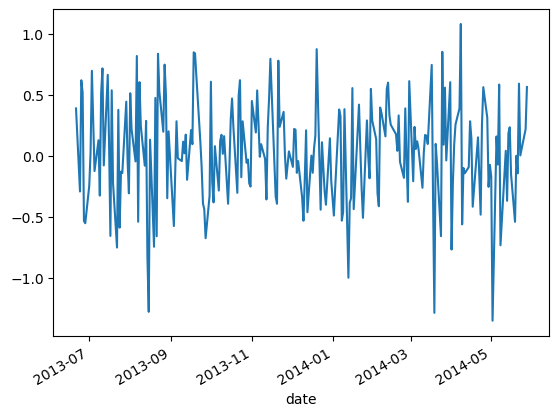

In [47]:
resid = autosarima_model.resid()
resid = resid[65:]
resid.plot()

<Axes: >

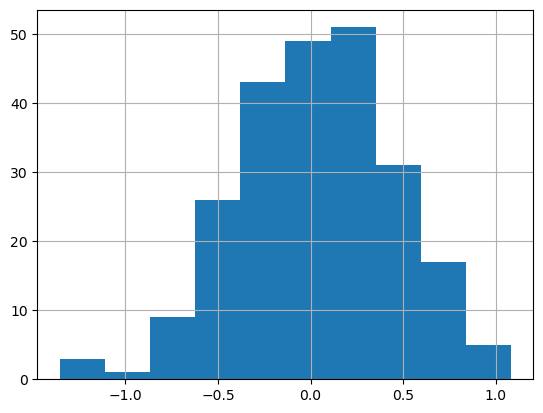

In [48]:
resid.hist()

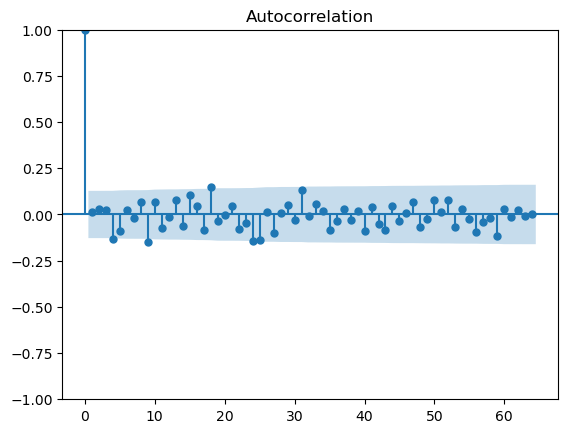

In [49]:
plot_acf(resid, lags=64)
plt.show()

In [50]:
sm.stats.acorr_ljungbox(resid, lags=[12], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,15.913221,0.195243,15.2998,0.225449


### residual analysis for non-seasonal arima

<Axes: xlabel='date'>

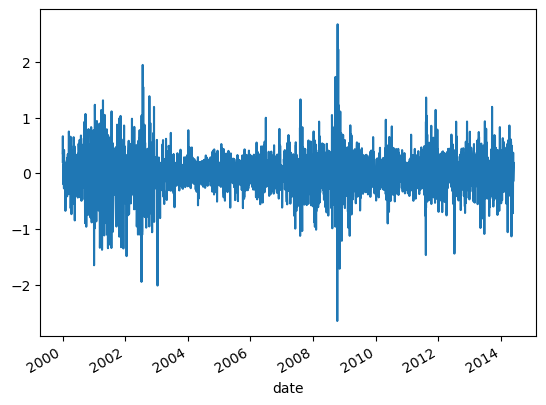

In [51]:
resid = autoarima_model.resid()
resid = resid[1:]
resid.plot()

<Axes: >

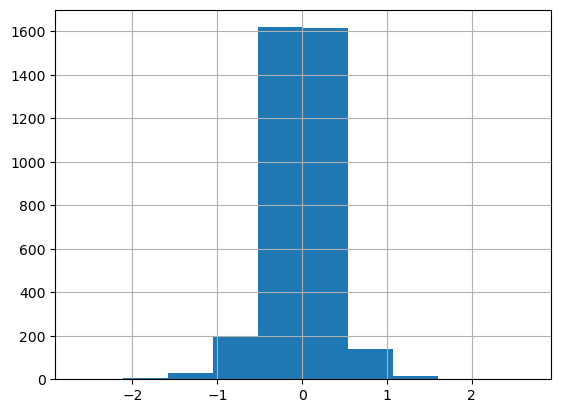

In [52]:
resid.hist()

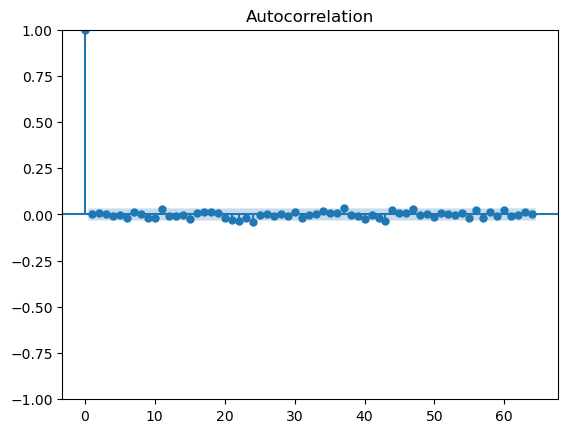

In [53]:
plot_acf(resid, lags=64)
plt.show()

In [54]:
sm.stats.acorr_ljungbox(resid, lags=[12], return_df=True, boxpierce=True)
# show strong autocorrelation in early lags, indicating importance for accounting seasonality in the model

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,9.509259,0.658927,9.480508,0.661433


In [55]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error,mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# error metrics for auto arima with seasonality parameter

In [57]:
y_pred = autosarima_model.predict(n_periods=len(val_duk))
mae_auto = mean_absolute_error(val_duk,y_pred)
mse_auto = mean_squared_error(val_duk, y_pred)
mape_auto = mean_absolute_percentage_error(val_duk, y_pred)*100
smape_auto = mean_absolute_percentage_error(val_duk, y_pred, symmetric = True)*100

In [59]:
print(f"MAE: {mae_auto}")
print(f"MSE: {mse_auto}")
print(f"MAPE: {mape_auto}")
print(f"sMAPE: {smape_auto}")

MAE: 4.553762294047783
MSE: 30.78262446836756
MAPE: 7.521503702555772
sMAPE: 7.919496725319848


# error metrics for auto arima without seasonality parameter

In [61]:
y_pred = autoarima_model.predict(n_periods=len(val_duk))
mae_auto2 = mean_absolute_error(val_duk,y_pred)
mse_auto2 = mean_squared_error(val_duk, y_pred)
mape_auto2 = mean_absolute_percentage_error(val_duk, y_pred)*100
smape_auto2 = mean_absolute_percentage_error(val_duk, y_pred, symmetric = True)*100

In [62]:
print(f"MAE: {mae_auto2}")
print(f"MSE: {mse_auto2}")
print(f"MAPE: {mape_auto2}")
print(f"sMAPE: {smape_auto2}")

MAE: 6.049492628394114
MSE: 51.97076702246319
MAPE: 9.912756613861534
sMAPE: 10.609497077342569


# Prophet

In [64]:
y_train_p = train_duk.copy()
y_train_p['y'] = y_train_p['adj_close']
y_train_p['ds'] = train_duk.index

In [67]:
model_1 = Prophet()
model_1.fit(y_train_p)

16:27:19 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
def calc_AIC(model,y_train_new):
    future = model.make_future_dataframe(periods=0)  # forecast only on the training data
    forecast = model.predict(future)

    # Calculate the residuals
    residuals = y_train_new['y'].values - forecast['yhat'].values
    
    # Calculate the log-likelihood
    n = len(y_train_new)
    sigma2 = np.var(residuals)
    log_likelihood = -n / 2 * (np.log(2 * np.pi) + np.log(sigma2) + 1)
    
    # Number of parameters (k)
    # Here, k is the number of parameters estimated by the model, including seasonality components.
    # For a basic model, you can approximate it as:
    k = 2 + 2 * model.seasonalities['yearly']['fourier_order']
    
    # Calculate AIC
    AIC = 2 * k - 2 * log_likelihood
    return AIC

In [69]:
model1 = Prophet()
model1.fit(y_train_p)
aic = calc_AIC(model1,y_train_p)
aic

16:27:32 - cmdstanpy - INFO - Chain [1] start processing
16:27:34 - cmdstanpy - INFO - Chain [1] done processing


11587.913281793994

In [70]:
model2 = Prophet()
model2.add_seasonality(name='quarterly', period =90, fourier_order=7, prior_scale=0.5)
model2.fit(y_train_p)
aic = calc_AIC(model2,y_train_p)
aic

16:27:37 - cmdstanpy - INFO - Chain [1] start processing
16:27:38 - cmdstanpy - INFO - Chain [1] done processing


11549.043579336874

In [71]:
model2 = Prophet()
model2.add_seasonality(name='weekly', period =7, fourier_order=3, prior_scale=0.5)
model2.fit(y_train_p)
aic = calc_AIC(model2,y_train_p)
aic

16:27:45 - cmdstanpy - INFO - Chain [1] start processing
16:27:47 - cmdstanpy - INFO - Chain [1] done processing


11563.80275778646

In [72]:
model3 = Prophet()
model3.add_seasonality(name='yearly', period =360, fourier_order=10, prior_scale=0.5)
model3.fit(y_train_p)
aic = calc_AIC(model3,y_train_p)
aic

16:27:52 - cmdstanpy - INFO - Chain [1] start processing
16:27:53 - cmdstanpy - INFO - Chain [1] done processing


11643.33420433691

In [73]:
result = []
for i in [0.001,0.05,0.1,1]:
    model4 = Prophet(yearly_seasonality=True, changepoint_prior_scale=i)
    model4.fit(y_train_p)
    
    aic = calc_AIC(model4,y_train_p)
    print(aic)

16:27:58 - cmdstanpy - INFO - Chain [1] start processing
16:27:59 - cmdstanpy - INFO - Chain [1] done processing


20386.516823318867


16:28:00 - cmdstanpy - INFO - Chain [1] start processing
16:28:01 - cmdstanpy - INFO - Chain [1] done processing


11587.913281793994


16:28:02 - cmdstanpy - INFO - Chain [1] start processing
16:28:03 - cmdstanpy - INFO - Chain [1] done processing


11293.73300412617


16:28:04 - cmdstanpy - INFO - Chain [1] start processing
16:28:05 - cmdstanpy - INFO - Chain [1] done processing


11160.710439353054


In [74]:
model_1 = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model_1.fit(y_train_p)

16:28:08 - cmdstanpy - INFO - Chain [1] start processing
16:28:09 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
if isinstance(val_duk.index, pd.DatetimeIndex):
    validation_dates = pd.DataFrame({'ds': val_duk.index})
else:

    validation_dates = pd.DataFrame({'ds': pd.to_datetime(val_duk['ds'])})


all_dates = pd.concat([
    model_1.history[['ds']],  
    validation_dates 
]).drop_duplicates().reset_index(drop=True)

future = pd.DataFrame({'ds': all_dates['ds']})

In [78]:
forecast = model_1.predict(future)

training_actuals = model_1.history[['ds', 'y']]
results = pd.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], training_actuals, on='ds', how='right')

results['residuals'] = results['y'] - results['yhat'] #training residual

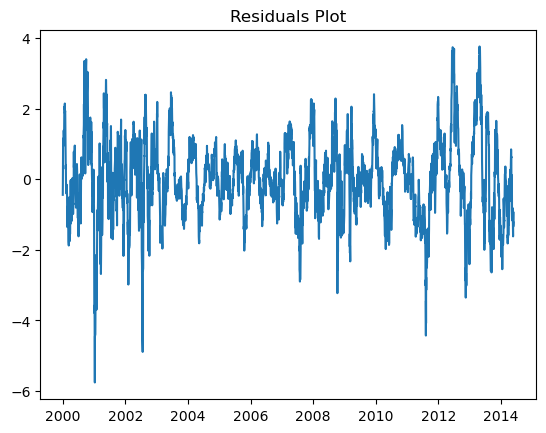

In [79]:
plt.plot(results['ds'], results['residuals'], label='Residuals')
plt.title('Residuals Plot')
plt.show()

<Axes: >

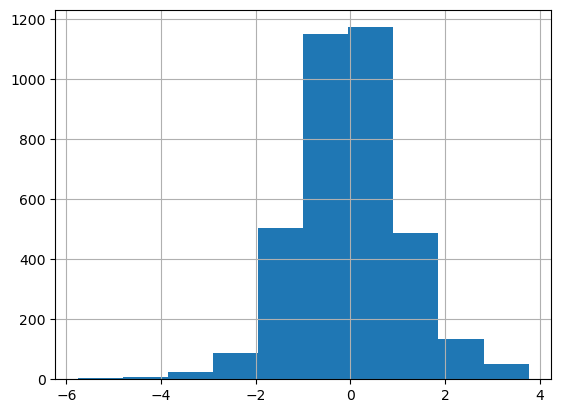

In [80]:
results['residuals'].hist()

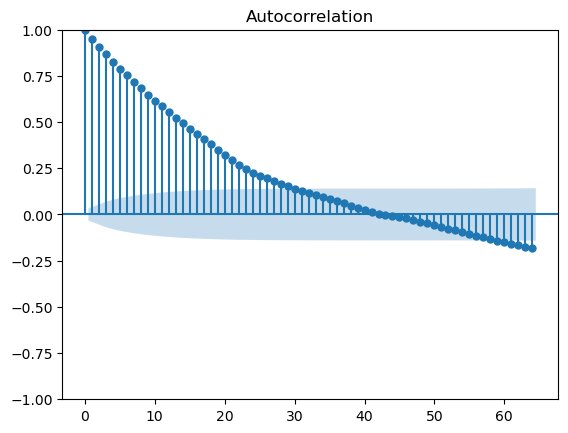

In [81]:
plot_acf(results['residuals'], lags=64)
plt.show()

In [82]:
sm.stats.acorr_ljungbox(results['residuals'], lags=[12], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,24642.886417,0.0,24592.757099,0.0


In [83]:
mae_prophet1 = mean_absolute_error(val_duk['adj_close'],forecast['yhat'][-len(val_duk):])
mse_prophet1 = mean_squared_error(val_duk['adj_close'],forecast['yhat'][-len(val_duk):])
mape_prophet1 = mean_absolute_percentage_error(val_duk['adj_close'],forecast['yhat'][-len(val_duk):])*100
smape_prophet1 = mean_absolute_percentage_error(val_duk['adj_close'],forecast['yhat'][-len(val_duk):], symmetric = True)*100

In [84]:
print(f"MAE: {mae_prophet1}")
print(f"MSE: {mse_prophet1}")
print(f"MAPE: {mape_prophet1}")
print(f"sMAPE: {smape_prophet1}")

MAE: 2.886531869175812
MSE: 13.137611896209103
MAPE: 5.069409228098507
sMAPE: 4.9847978529638


In [111]:
df = DUK.reset_index().rename(columns={'date': 'ds', 'adj_close': 'y'})
df

,ds,y
0,2000-01-03,13.823437
1,2000-01-04,14.038309
2,2000-01-05,14.700115
3,2000-01-06,15.006666
4,2000-01-07,15.399166
...,...,...
6032,2023-12-22,94.851479
6033,2023-12-26,94.724175
6034,2023-12-27,94.303092
6035,2023-12-28,94.910235


In [97]:
cutoffs = pd.date_range(start='2001-01-01', end='2013-01-01', freq='AS')
df_cv = cross_validation(model_1, cutoffs=cutoffs, horizon='365 days')


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/13 [00:00<?, ?it/s]

16:39:36 - cmdstanpy - INFO - Chain [1] start processing
16:39:36 - cmdstanpy - INFO - Chain [1] done processing
16:39:36 - cmdstanpy - INFO - Chain [1] start processing
16:39:37 - cmdstanpy - INFO - Chain [1] done processing
16:39:37 - cmdstanpy - INFO - Chain [1] start processing
16:39:37 - cmdstanpy - INFO - Chain [1] done processing
16:39:37 - cmdstanpy - INFO - Chain [1] start processing
16:39:38 - cmdstanpy - INFO - Chain [1] done processing
16:39:38 - cmdstanpy - INFO - Chain [1] start processing
16:39:39 - cmdstanpy - INFO - Chain [1] done processing
16:39:39 - cmdstanpy - INFO - Chain [1] start processing
16:39:40 - cmdstanpy - INFO - Chain [1] done processing
16:39:40 - cmdstanpy - INFO - Chain [1] start processing
16:39:41 - cmdstanpy - INFO - Chain [1] done processing
16:39:41 - cmdstanpy - INFO - Chain [1] start processing
16:39:42 - cmdstanpy - INFO - Chain [1] done processing
16:39:42 - cmdstanpy - INFO - Chain [1] start processing
16:39:43 - cmdstanpy - INFO - Chain [1]

In [98]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,6.773475,2.602590,1.891149,0.082595,0.052745,0.082900,0.457493
1,38 days,6.906607,2.628042,1.916359,0.083581,0.053557,0.083905,0.457055
2,39 days,7.006500,2.646979,1.934052,0.084634,0.053824,0.085202,0.457055
3,40 days,7.049992,2.655182,1.938278,0.085218,0.054250,0.086034,0.458078
4,41 days,7.128083,2.669847,1.951373,0.086181,0.055403,0.087172,0.458589


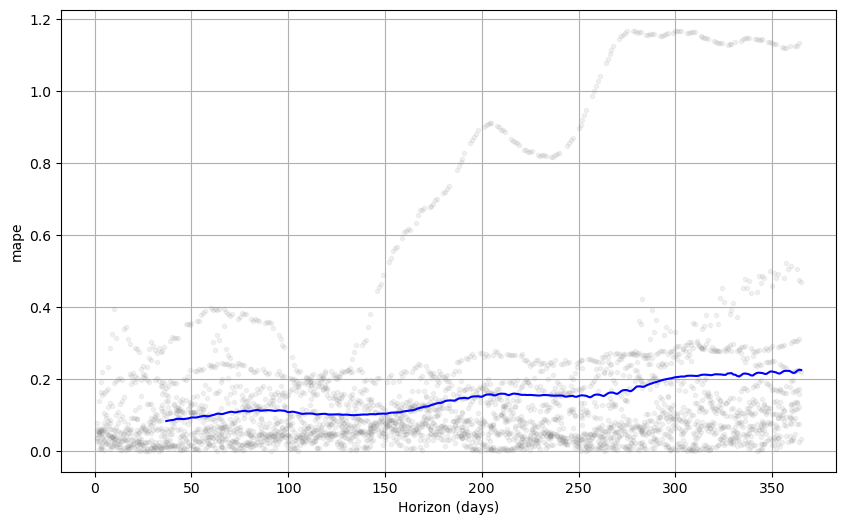

In [99]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [112]:
import itertools


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:49:29 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:49:36 - cmdstanpy - INFO - Chain [1] start processing
16:49:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:49:42 - cmdstanpy - INFO - Chain [1] start processing
16:49:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:49:48 - cmdstanpy - INFO - Chain [1] start processing
16:49:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  5.569958
1                     0.001                     0.10  5.673699
2                     0.001                     1.00  5.764145
3                     0.001                    10.00  5.666594
4                     0.010                     0.01  2.960229
5                     0.010                     0.10  2.886283
6                     0.010                     1.00  2.895871
7                     0.010                    10.00  2.914857
8                     0.100                     0.01  2.755000
9                     0.100                     0.10  2.658330
10                    0.100                     1.00  2.657161
11                    0.100                    10.00  2.648901
12                    0.500                     0.01  2.494652
13                    0.500                     0.10  2.504100
14                    0.500                     1.00  2

In [114]:
modeltuned = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10)
modeltuned.fit(y_train_p)
future_data = modeltuned.make_future_dataframe(periods=2*12, freq='m')
forecast_data = modeltuned.predict(future_data)

16:53:56 - cmdstanpy - INFO - Chain [1] start processing
16:53:58 - cmdstanpy - INFO - Chain [1] done processing


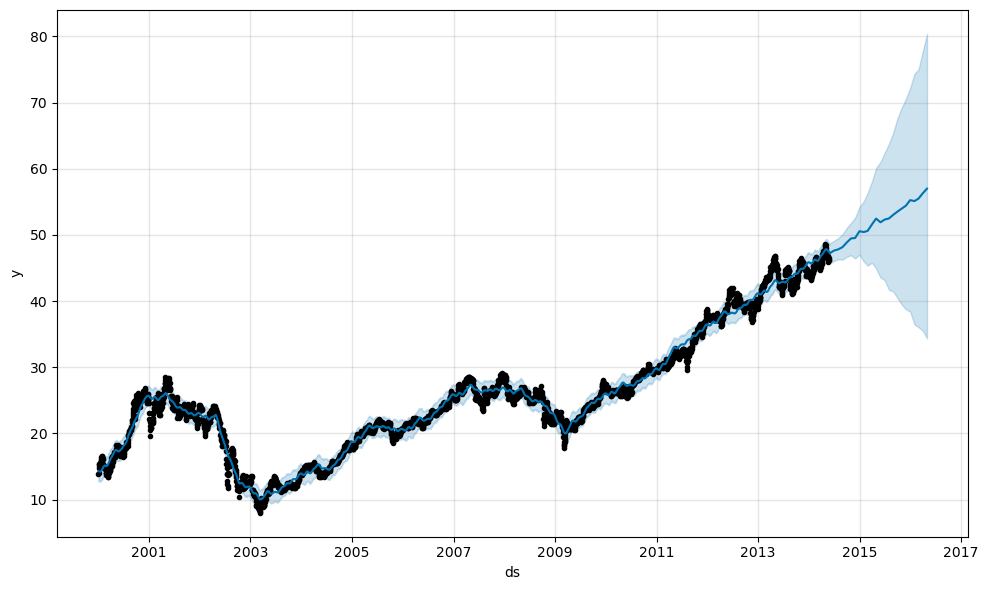

In [115]:
p = modeltuned.plot(forecast_data)
plt.show()

In [117]:
def error_metrics_prophet(model, train, test):
    # Prepare future dataframe for Prophet to make predictions on test set
    future = pd.DataFrame(test.ds)
    forecast = model.predict(future)
    
    # Extract forecasted values aligning with the test set
    y_pred = forecast['yhat'].values
    
    # Calculating error metrics
    mae = mean_absolute_error(test['y'], y_pred)
    mse = mean_squared_error(test['y'], y_pred)
    mape = mean_absolute_percentage_error(test['y'], y_pred)
    smape = np.mean(2 * np.abs(y_pred - test['y'].values) / (np.abs(test['y'].values) + np.abs(y_pred) + np.finfo(float).eps))

    # Naive forecast using the last observation from training set
    naive_forecast = train['y'].iloc[-1]
    naive_errors = np.abs(train['y'] - naive_forecast).mean()  # Mean absolute error of the naive forecast
    
    # MASE calculation
    mase = mae / naive_errors

    # Compiling metrics into a DataFrame
    df_metrics = pd.DataFrame({
        'MAE': [mae],
        'MSE': [mse],
        'MAPE': [mape],
        'sMAPE': [smape],
        'MASE': [mase]
    })

    return df_metrics

In [120]:
val_duk_p = val_duk.reset_index().rename(columns={'date': 'ds', 'adj_close': 'y'})

In [121]:
error_metrics_prophet(modeltuned, y_train_p, val_duk_p)

,MAE,MSE,MAPE,sMAPE,MASE
0,2.887188,13.141388,0.050705,0.049858,0.137669


# VAR

In [144]:
hw1 = pd.read_csv('hw1_data.csv')
hw1['Date'] = pd.to_datetime(hw1['Date'])
hw1.set_index('Date', inplace=True)

DUK.index = pd.to_datetime(DUK.index)

SPY = hw1[['SPY']]

varma_duk = DUK.merge(SPY, left_index=True, right_index=True, how='left').dropna()

# Display the merged DataFrame
varma_duk

,adj_close,SPY
date,,
2000-05-26,17.473868,93.363678
2000-05-30,17.073614,96.408173
2000-05-31,17.146653,96.619591
2000-06-01,16.983046,98.310966
2000-06-02,16.854497,100.023491
...,...,...
2020-02-26,83.087097,305.789459
2020-02-27,79.769995,292.055939
2020-02-28,77.007143,290.828827


In [141]:
train_var_duk, val_var_duk, test_var_duk = data.split_time_series(varma_duk, 0.6,0.2)

In [145]:
from statsmodels.tsa.vector_ar.var_model import VAR

var_model = VAR(varma_duk).fit()
yhat = var_model.forecast(var_model.endog, steps=1)
print(yhat)

[[ 80.31590923 294.84128564]]


In [146]:
var_model=VAR(train_var_duk)

results_aic =[]
for p in range(1,10):
    results = var_model.fit(p)
    results_aic.append(results.aic)

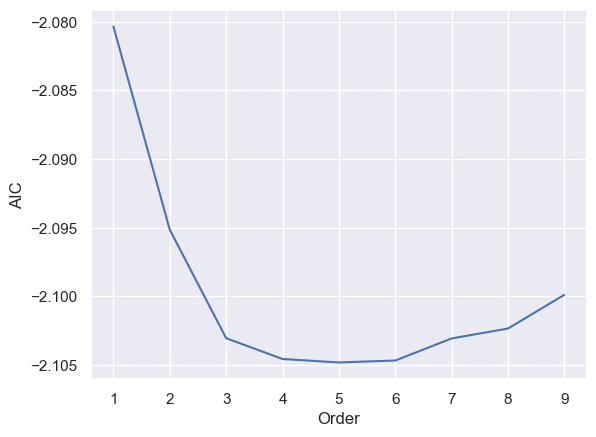

In [147]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

Here we can see that the lowest AIC score is achieved at order of 5. We will proceed with BIC next to see it it matches.


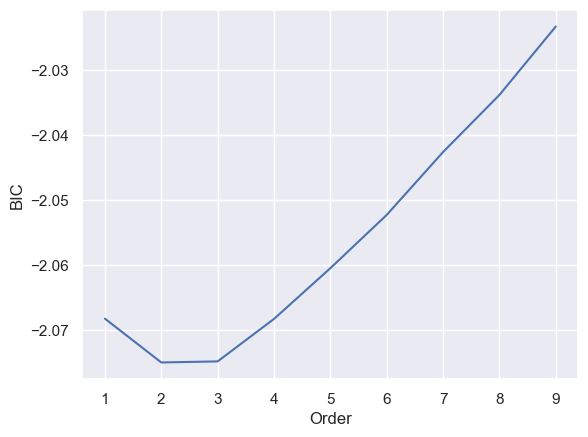

In [148]:
results_bic =[]
for p in range(1,10):
    results = var_model.fit(p)
    results_bic.append(results.bic)
    

plt.plot(list(np.arange(1,10,1)), results_bic)
plt.xlabel("Order")
plt.ylabel("BIC")
plt.show()

However, the textbook suggests us to use BIC, here we have lowest BIC score at order 2, which will be a more parsimonious model, so we will choose Var(2).

In [149]:
results = var_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, May, 2024
Time:                     17:18:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.07501
Nobs:                     2981.00    HQIC:                  -2.08790
Log likelihood:          -5326.90    FPE:                   0.123053
AIC:                     -2.09514    Det(Omega_mle):        0.122641
--------------------------------------------------------------------
Results for equation adj_close
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.037853         0.039401           -0.961           0.337
L1.adj_close         0.950445         0.020792           45.712           0.000
L1.SPY              -0.020377         0.006627           -3.

In [157]:
len(test_var_duk)

995

In [158]:
yhat = results.forecast(var_model.endog, steps=995)

In [159]:
idx=test_var_duk.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['duk_forecast', 'spy_forecast']]

<Axes: xlabel='date'>

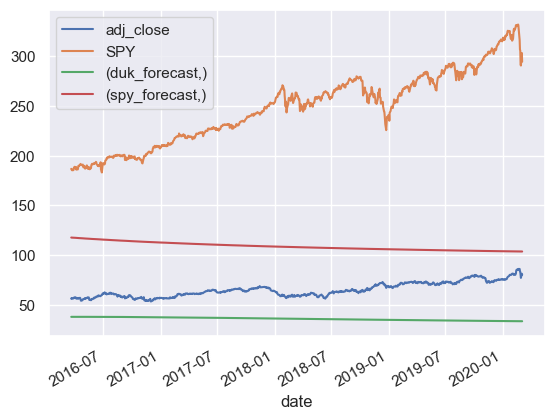

In [160]:
df_results = pd.concat([test_var_duk,df_preds], axis=1)
df_results.plot()

In [178]:
df_results.columns = [col[0] if isinstance(col, tuple) else col for col in df_results.columns]

In [181]:
print('VAR DUK RMSE: ' + str(sqrt(mean_squared_error(df_results['adj_close'],df_results['duk_forecast']))))
print('VAR SPY RMSE: ' + str(sqrt(mean_squared_error(df_results['SPY'],df_results['spy_forecast']))))

VAR DUK RMSE: 30.4234884818589
VAR SPY RMSE: 144.821307169452


# VMA

In [182]:
df_diff = varma_duk.diff(1).dropna()

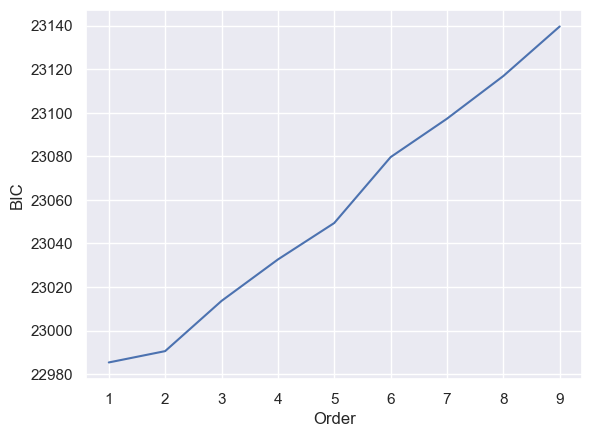

In [185]:
results_bic =[]
for q in range(1,10):
    model = VARMAX(df_diff, order= (0,q))
    results = model.fit(maxiter=200, disp=False)
    results_bic.append(results.bic)
    

plt.plot(list(np.arange(1,10,1)), results_bic)
plt.xlabel("Order")
plt.ylabel("BIC")
plt.show()

In [186]:
vma_model = VARMAX(df_diff, order= (0,1))
results = vma_model.fit(maxiter=1000, disp=False)

In [187]:
results.summary()

Dep. Variable:,"['adj_close', 'SPY']",No. Observations:,4971
Model:,VMA(1),Log Likelihood,-11454.381
,+ intercept,AIC,22926.761
Date:,"Thu, 23 May 2024",BIC,22985.364
Time:,17:49:50,HQIC,22947.307
Sample:,0,,
,- 4971,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.04, 0.00",Jarque-Bera (JB):,"8964.85, 15040.64"
Prob(Q):,"0.85, 0.99",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.63, 4.81",Skew:,"-0.46, -0.78"


The results are so poor, no need to proceed with evaluation.

# VARMA

In [188]:
varma_model = VARMAX(df_diff, order=(1, 1)).fit(disp=False)
yhat = varma_model.forecast(steps=1)
print(yhat)

      adj_close       SPY
4971   0.062485  0.442422


In [189]:
varma_model.summary()

Dep. Variable:,"['adj_close', 'SPY']",No. Observations:,4971
Model:,"VARMA(1,1)",Log Likelihood,-11445.393
,+ intercept,AIC,22916.786
Date:,"Thu, 23 May 2024",BIC,23001.434
Time:,17:51:43,HQIC,22946.463
Sample:,0,,
,- 4971,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.11, 0.23",Jarque-Bera (JB):,"8689.27, 15104.09"
Prob(Q):,"0.74, 0.64",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.63, 4.75",Skew:,"-0.47, -0.83"


In [190]:
yhat = varma_model.forecast(steps=995)

In [192]:
idx=test_var_duk.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['duk_forecast', 'spy_forecast']]

In [193]:
df_results = pd.concat([test_var_duk,df_preds], axis=1)

In [194]:
df_results.columns = [col[0] if isinstance(col, tuple) else col for col in df_results.columns]

In [195]:
print('VARMA DUK RMSE: ' + str(sqrt(mean_squared_error(df_results['adj_close'],df_results['duk_forecast']))))
print('VARMA SPY RMSE: ' + str(sqrt(mean_squared_error(df_results['SPY'],df_results['spy_forecast']))))

VARMA DUK RMSE: 65.3753868408096
VARMA SPY RMSE: 250.5229970206969
